In [1]:
%matplotlib inline
%load_ext memory_profiler

import os 
import glob 
import sys
sys.path.append('/home/ngr4/project/edge_feat/scripts')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils
import load_data as data
import math
import numpy as np
import pandas as pd
import seaborn as sns
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import graphtools as gt
import phate
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scanpy as sc
from scipy import sparse
import scprep
import time
import datetime
from scipy.stats import zscore
from adjustText import adjust_text


from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

from captum.attr import (
#     GradientShap,
#     DeepLift,
#     DeepLiftShap,
    IntegratedGradients,
#     LayerConductance,
#     NeuronConductance,
    NoiseTunnel,
)



plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

In [2]:
# aesthetics
# cmap_timepoint = {v:sns.light_palette((210, 90, 60), input="husl")[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_timepoint = {v:sns.color_palette('BuGn')[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_genotime = {}
for g in ['WT', 'SCA1']:
    if g=='WT':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5, start=.5, rot=-.75)[i]
    if g=='SCA1':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5)[i]
            
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE'}

cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}



In [3]:
def load_adata(fname,backed=None) : 
    """Load adata object. 
    
    Arguments:
        fname (str): full filename with filepath
        
    Returns:
        (AnnData)
        
    """
    start = time.time()
    adata = sc.read_h5ad(filename=fname,backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata


if False:
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'
    
    # load human
    fname='mouse_200614.h5ad'
    adata = load_adata(os.path.join(pdfp, fname))

In [4]:
class Encoder(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, s_max, d_model, num_heads, ln=False, skip=True):
        super(Encoder, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.skip = skip
        self.s_max = s_max
        #Maximum set size
        self.d_model = d_model
        self.fc_q = nn.Linear(dim_Q, d_model)
        self.fc_k = nn.Linear(dim_K, d_model)
        self.fc_v = nn.Linear(dim_K, d_model)
        if ln:
            self.ln0 = nn.LayerNorm(d_model)
            self.ln1 = nn.LayerNorm(d_model)
        #This is the classic pointwise feedforward in "Attention is All you need"
        self.ff = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.ReLU(),
        nn.Linear(4 * d_model, d_model))
        self.fc_rep = nn.Linear(s_max, 1)
        
    # number of heads must divide output size = d_model
    def forward(self, Q, K, return_attention, return_A):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)
        dim_split = self.d_model // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
        A = torch.softmax(Q_.bmm(K_.transpose(-2,-1))/math.sqrt(self.d_model), dim=-1)
        A_1 = A.bmm(V_) 
        O = torch.cat((A_1).split(Q.size(0), 0), 2) 
        if return_attention:
            attn = O
        O = torch.cat((Q_ + A_1).split(Q.size(0), 0), 2) if getattr(self, 'skip', True) else \
             torch.cat((A_1).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)

        # For the classic transformers paper it is
        O = O + self.ff(O)
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        O = O.transpose(-2,-1)
        O = F.pad(O, (0, self.s_max- O.shape[-1]), 'constant', 0)
        O = self.fc_rep(O)
        O = O.squeeze() 
        if return_attention:
            return O, attn
        elif return_A:
            return O, A
        else:
            return O
    
class SelfAttention_batch(nn.Module):
    def __init__(self, s_max, dim_in=18, dim_out=8, num_heads=2, ln=True, skip=True):
        super(SelfAttention_batch, self).__init__()
        self.Encoder = Encoder(dim_in, dim_in, dim_in, s_max, dim_out, num_heads, ln=ln, skip=skip)
        
    def forward(self, X, return_attention=True, return_A=False):
        return self.Encoder(X, X, return_attention, return_A)
    
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=d.y.unique().size()[0],
                                 heads=8, concat=False, negative_slope=0.2,
                                 dropout=0.4, bias=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        hprime = x # store embeddings 
        x = F.elu(x)
        x, attn_gat2 = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1), attn_gat1, attn_gat2, hprime
    
    
class GAT_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GAT_transformer_mlp_batch, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        x = F.elu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x, attn_gat2 = self.gat2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans, attn_gat1, attn_gat2
    
class GCN_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GCN_transformer_mlp_batch, self).__init__()
        self.conv1 = GCNConv(d.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans
    
    
# other utils fx 
def load_pkl(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

def adata_phate(adata):
    # compute PHATE
    G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=0,
                           random_state=42)
    adata.obsm['X_phate']=phate_op.fit_transform(G.K)
    
    return adata

In [5]:
def main(d, **kwargs):
    
    batch_it = False 
    
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        s_max = kwargs['s_max']
        if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GCN_transformer_mlp_batch()
        elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GAT_transformer_mlp_batch()
    elif 'GAT'== kwargs['model']:
        model = GAT()
    model.eval()
    model.load_state_dict(torch.load(kwargs['modeleval_pkl'], map_location=torch.device('cpu')))
    
    if batch_it:
        # TODO: not implemented for GCN 
        cd_test = data.ClusterData(d,5000)
        cl_test = data.ClusterLoader(cd_test,256,shuffle=True)

        batch_loss_test = []
        batch_acc_test = []

        for batch in cl_test:
            output, attn_trans, attn_gat1, attn_gat2 = model(batch, utils.edge_set_reshape(batch).float())
            loss_test = F.nll_loss(output, batch.y)
            batch_acc_test.append(utils.accuracy(output,batch.y).item())
            batch_loss_test.append(loss_test.item())
        print('Test set results:')
        print('  <loss>_bacth={:.4f}'.format(np.mean(batch_loss_test)))
        print('  <acc>_batch ={:.4f}'.format(np.mean(batch_acc_test)))
    else:
        if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans = model(d, utils.edge_set_reshape(d).float())
            elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans, attn_gat1, attn_gat2 = model(d, utils.edge_set_reshape(d).float())
        elif 'GAT'== kwargs['model']:
            output, attn_gat1, attn_gat2, hprime = model(d)
        loss_test = F.nll_loss(output, d.y)
        acc_test = utils.accuracy(output,d.y).item()
        print('Test set results:')
        print('  loss: {:.4f}'.format(loss_test))
        print('  accuracy: {:.4f}'.format(acc_test))
        
    datapkl = load_pkl(kwargs['data_pkl'])
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        return attn_gat1, attn_trans, datapkl, model, output # returns for only one batch if batch_it = True
    elif 'GAT'== kwargs['model']:
        return attn_gat1, attn_gat2, datapkl, model, output, hprime # returns for only one batch if batch_it = True

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ss(x):
    """Sum of squares divided by sqrt N."""
    return np.sum(x**2)/np.sqrt(x.shape[0])

In [6]:
# modify 

pfp = '/home/ngr4/project/scnd/results'
pdfp = '/home/ngr4/project/scnd/data/processed'

featnames = load_pkl(os.path.join(pdfp,'scnd_feat_names.pkl'))

params = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gattransmlpbatch/581-hbec_it_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gattransmlpbatch',
        's_max': 36, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params_gcn = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gcntransmlpbatch/705-hbec_gt_gcntransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gcntransmlpbatch',
        's_max': 41, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params5wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_5wk/151-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_5wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params12wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_12wk/138-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_12wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params18wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_18wk/81-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_18wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params24wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_24wk/224-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_24wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params30wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_30wk/72-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_30wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params_sca1 = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1/51-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'ysca1',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params_gt = { #genotime

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/genotype_time/584-scnd_gt1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'ygenotime',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }




### Integrated gradients for WT v. MUT

In [7]:
# modify class
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=d.y.unique().size()[0],
                                 heads=8, concat=False, negative_slope=0.2,
                                 dropout=0.4, bias=True)

    def forward(self, x, edge_index):
#         x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        hprime = x # store embeddings 
        x = F.elu(x)
        x, attn_gat2 = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    
def main(d, **kwargs):
    
    batch_it = False 
    
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        s_max = kwargs['s_max']
        if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GCN_transformer_mlp_batch()
        elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GAT_transformer_mlp_batch()
    elif 'GAT'== kwargs['model']:
        model = GAT()
    model.eval()
    model.load_state_dict(torch.load(kwargs['modeleval_pkl'], map_location=torch.device('cpu')))
    
    if batch_it:
        # TODO: not implemented for GCN 
        cd_test = data.ClusterData(d,5000)
        cl_test = data.ClusterLoader(cd_test,256,shuffle=True)

        batch_loss_test = []
        batch_acc_test = []

        for batch in cl_test:
            output, attn_trans, attn_gat1, attn_gat2 = model(batch, utils.edge_set_reshape(batch).float())
            loss_test = F.nll_loss(output, batch.y)
            batch_acc_test.append(utils.accuracy(output,batch.y).item())
            batch_loss_test.append(loss_test.item())
        print('Test set results:')
        print('  <loss>_bacth={:.4f}'.format(np.mean(batch_loss_test)))
        print('  <acc>_batch ={:.4f}'.format(np.mean(batch_acc_test)))
    else:
        if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans = model(d, utils.edge_set_reshape(d).float())
            elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans, attn_gat1, attn_gat2 = model(d, utils.edge_set_reshape(d).float())
        elif 'GAT'== kwargs['model']:
            output = model(d.x, d.edge_index)
        loss_test = F.nll_loss(output, d.y)
        acc_test = utils.accuracy(output,d.y).item()
        print('Test set results:')
        print('  loss: {:.4f}'.format(loss_test))
        print('  accuracy: {:.4f}'.format(acc_test))
        
    datapkl = load_pkl(kwargs['data_pkl'])
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        return attn_gat1, attn_trans, datapkl, model, output # returns for only one batch if batch_it = True
    elif 'GAT'== kwargs['model']:
        return datapkl, model, output # returns for only one batch if batch_it = True

def custom_forward(x, edge_index):
    return model(x.squeeze(), edge_index[0])

In [8]:
# load model
for params in [params]:
    kwargs = params
    d = data.get_data(kwargs['data_pkl'], kwargs['label'], 
                           kwargs['sample'], None, 
                           kwargs['load_attn1'], kwargs['load_attn2'],
                           kwargs['modelpkl_fname1'], kwargs['modelpkl_fname2'],
                           kwargs['preloadn2v'], out_channels=8, 
                           heads=8, negative_slope=0.2, 
                           dropout=0.4)
    s_max = kwargs['s_max'] # scope is incorrect when in fx
    datapkl, model, output = main(d, **kwargs) # attn_trans, attn_gat1, datapkl, model IF transformer eval
    
    # print various metrics 
    y_true = datapkl[kwargs['label']]
    p1 = np.exp(output.detach().numpy()[:,1])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_true, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_true,p1)
    ap = metrics.average_precision_score(y_true,p1)
    bs = metrics.brier_score_loss(y_true,p1)
    f1 = metrics.f1_score(y_true,optimal_pred)
    acc = metrics.accuracy_score(y_true,optimal_pred)

    print('{} results'.format(kwargs['label']))
    print('-----------------------')
    print('Accuracy      : {:.4f}'.format(acc))
    print('Sensitivity   : {:.4f}'.format(tpr[optimal_idx]))
    print('Specificity   : {:.4f}'.format(1-fpr[optimal_idx]))
    print('')
    print('Ave. precision: {:.4f}'.format(ap))
    print('Precision     : {:.4f}'.format(1-precision[optimal_idx])) # not sure about this
    print('Recall        : {:.4f}'.format(recall[optimal_idx])) # not sure about this
    print('')
    print('AU-ROC        : {:.4f}'.format(auroc))
    print('AU-PRC        : {:.4f}'.format(auprc))
    print('Brier         : {:.4f}'.format(bs))
    print('F1            : {:.4f}'.format(f1))
    
    # check confusion matrix 
    print('\nConfusion matrix: (i-th truth, j-th pred)')
    print(metrics.confusion_matrix(y_true, optimal_pred))

Test set results:
  loss: 0.3733
  accuracy: 0.8386
ysca1 results
-----------------------
Accuracy      : 0.8393
Sensitivity   : 0.8430
Specificity   : 0.8359

Ave. precision: 0.9203
Precision     : 0.4328
Recall        : 0.9894

AU-ROC        : 0.9154
AU-PRC        : 0.9203
Brier         : 0.1174
F1            : 0.8342

Confusion matrix: (i-th truth, j-th pred)
[[9274 1821]
 [1607 8625]]


In [10]:
ig = IntegratedGradients(custom_forward)
nt = NoiseTunnel(ig)

# for gtype, timepoint, ctype --> get importance scores by averaging expression in that group
md = pd.DataFrame({'genotype':datapkl['genotype'],
                  'timepoint':datapkl['timepoint'],
                  'ctype':datapkl['ctype']},
                  index=list(range(len(datapkl['genotype']))))

ignt = pd.DataFrame() 
emd = pd.DataFrame()
for i in ['SCA1']:#np.unique(datapkl['genotype']): # only select label group or average altogether?
    for j in np.unique(datapkl['timepoint']):
        for k in np.unique(datapkl['ctype']):
            idx = md.loc[(md['genotype']==i) & (md['timepoint']==j) & (md['ctype']==k),:].index.to_list()
            if len(idx)==0:
                print('No cells for {}, {}, {}'.format(i,j,k))
                continue
            X = torch.tensor(np.mean(np.asarray(datapkl['X'])[idx, :], axis=0)).unsqueeze(0)
            attr = nt.attribute(X, 
                                additional_forward_args=((torch.tensor([0,0]).unsqueeze(0))), 
                                nt_type='smoothgrad',  
                                n_samples=10, 
                                target=1)
            dt = pd.DataFrame({'ig+nt':attr.squeeze().numpy(), 
                               'Gene':featnames})
            dt['genotype'] = i
            dt['timepoint'] = j
            dt['ctype'] = k
            wt_idx = md.loc[(md['genotype']=='WT') & (md['timepoint']==j) & (md['ctype']==k),:].index.to_list()
            if len(wt_idx)==0:
                print('No cells for {}, {}, {}'.format('WT',j,k))
                continue
            emd = scprep.stats.differential_expression(np.asarray(datapkl['X'])[idx, :],
                                     np.asarray(datapkl['X'])[wt_idx, :],
                                   measure = 'emd',
                                   direction='both', 
                                   gene_names=featnames,
                                   n_jobs=-1).reset_index().rename(columns={'index':'Gene'})
            dt = dt.merge(emd, left_on='Gene', right_on='Gene')
            ignt = ignt.append(dt, ignore_index=True)
                
            

In [11]:
load = True

if not load:
    ignt.to_csv(os.path.join(pfp, 'integrated_grads+noise_tunnel_7ptest.csv'))
else: 
    ignt = pd.read_csv(os.path.join(pfp, 'integrated_grads+noise_tunnel_7ptest.csv'))

In [13]:
# visualize 
dt = ignt # use full thing
if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'mt-' in g] + ['Malat1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]

topn = 50
x = (dt['ig+nt'].abs() - dt['ig+nt'].abs().min()) / (dt['ig+nt'].abs().max() - dt['ig+nt'].abs().min())
y = (dt['emd'].abs() - dt['emd'].abs().min()) / (dt['emd'].abs().max() - dt['emd'].abs().min())
dt['normed_ignt+emd'] = x+y
topn_idx = dt.sort_values(by='normed_ignt+emd', ascending=False).iloc[0:topn, :].index.to_list()
    
if False:
    # plot
    fig, ax = plt.subplots(1,1, figsize=(5,4))

    p1 = sns.scatterplot(
        x='emd',
        y='ig+nt',
        hue='ctype',
        style='timepoint',
        size=None,
        data=dt,
        palette=cmap_ctype,
        hue_order=None,
        hue_norm=None,
        sizes=None,
        size_order=None,
        size_norm=None,
        markers=True,
        style_order=None,
        x_bins=None,
        y_bins=None,
        units=None,
        estimator=None,
        ci=95,
        n_boot=1000,
        alpha=0.6,
        x_jitter=None,
        y_jitter=None,
        legend='brief',
        linewidth=0,
        s=6,
        rasterized=True,
        ax=ax,)

    ax.legend(bbox_to_anchor=(1,1))
    texts = [ax.text(dt.loc[ii, 'emd'], dt.loc[ii, 'ig+nt'], dt.loc[ii, 'Gene'], fontsize=6) for ii in topn_idx]
    adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)


    fig.savefig(os.path.join(pfp, 'emdVig+nt_test7p.pdf'), bbox_inches='tight', dpi=600)






/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


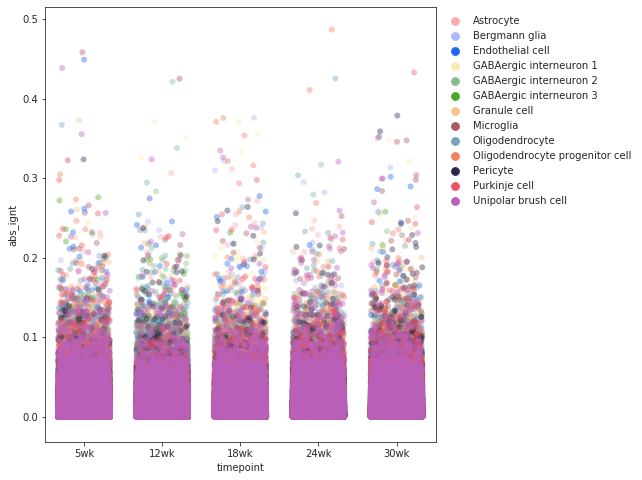

In [14]:
# visualize with categorical plot
topn = 50
dt['abs_ignt'] = dt['ig+nt'].abs()
dt.sort_values(by='abs_ignt', ascending=False).iloc[0:topn, :].index.to_list()    

fig, ax = plt.subplots(1,1, figsize=(7,8))

# dtt = dt.loc[dt['abs_ignt']>0.2, :]
# dtt=dtt.append(dt.loc[dt['abs_ignt']<=0.2, :].sample(100000))

p1 = sns.stripplot(
    x='timepoint',
    y='abs_ignt',
    hue='ctype',
    data=dt,
    order=['5wk','12wk','18wk','24wk','30wk'],
    hue_order=None,
    jitter=0.33,
    dodge=False,
    orient=None,
    color=None,
    palette=cmap_ctype,
    edgecolor='gray',
    linewidth=0,
    ax=ax,
    alpha=0.4,
    s=6,
)

# p1 = sns.stripplot(
#     x='timepoint',
#     y='ig+nt',
#     hue='ctype',
#     size=None,
#     data=dt.sample(10000),
#     palette=cmap_ctype,
#     hue_order=None,
#     hue_norm=None,
#     sizes=None,
#     size_order=None,
#     size_norm=None,
#     markers=True,
#     style_order=None,
#     x_bins=None,
#     y_bins=None,
#     units=None,
#     estimator=None,
#     ci=95,
#     n_boot=1000,
#     alpha=0.6,
#     x_jitter=True,
#     y_jitter=None,
#     legend='brief',
#     linewidth=0,
#     s=6,
#     rasterized=True,
#     ax=ax,)

ax.legend(bbox_to_anchor=(1,1))
# texts = [ax.text(dt.loc[ii, 'timepoint'], dt.loc[ii, 'abs_ignt'], dt.loc[ii, 'Gene'], fontsize=6) for ii in topn_idx]
# adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)


fig.savefig(os.path.join(pfp, 'emdVig+nt_timepoint_test7p.png'), bbox_inches='tight', dpi=600)




